<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
data = pd.read_csv('titanic.csv', index_col='PassengerId')

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
# ANSWER
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.shape

(891, 11)

In [5]:
# checking for missing value
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [22]:
def facetgridplot(train, var):
    facet = sns.FacetGrid(train, hue="Survived", aspect=4)
    facet.map(sns.kdeplot, var, shade= True)
    facet.set(xlim=(0, train[var].max()))
    facet.add_legend()
    plt.show();

In [7]:
def bar_chart(df, feature):
    survived = df[df['Survived']==1][feature].value_counts(normalize=True)*100
    dead = df[df['Survived']==0][feature].value_counts(normalize=True)*100
    data = pd.DataFrame([survived,dead])
    data.index = ['Survived','Dead']
    data.plot(kind='bar',stacked=True, figsize=(10,5))

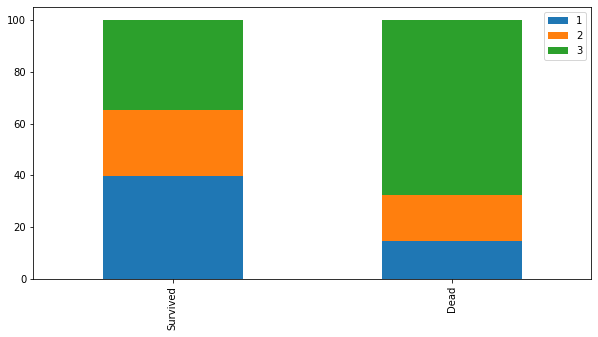

In [16]:
#Pclass
bar_chart(data, 'Pclass')

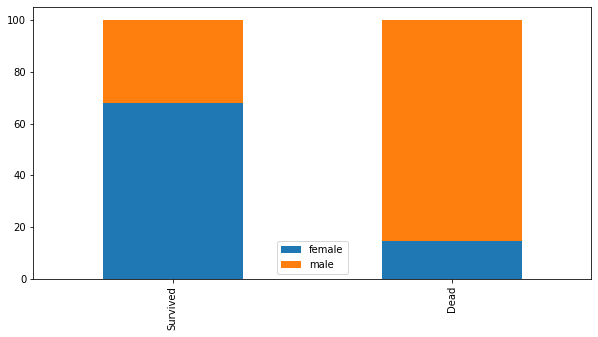

In [17]:
# Sex
bar_chart(data, 'Sex')

In [18]:
# Find median age by sex

data.groupby("Sex")["Age"].median()

Sex
female    27.0
male      29.0
Name: Age, dtype: float64

In [19]:
# The following is an array of the median age by sex
data.groupby("Sex")["Age"].transform("median")

PassengerId
1      29.0
2      27.0
3      27.0
4      27.0
5      29.0
       ... 
887    29.0
888    27.0
889    27.0
890    29.0
891    29.0
Name: Age, Length: 891, dtype: float64

In [20]:
# fill missing age with median age for each sex (0 (male), 1 (female)) in new column
data["New_age"] = data["Age"].fillna(   data.groupby("Sex")["Age"].transform("median")    )

# check values
data[data['Age'].isnull()][['Sex', 'Age', 'New_age']].head(10)

,Sex,Age,New_age
PassengerId,,,
6,male,NaN,29.0
18,male,NaN,29.0
20,female,NaN,27.0
27,male,NaN,29.0
29,female,NaN,27.0
30,male,NaN,29.0
32,female,NaN,27.0
33,female,NaN,27.0
37,male,NaN,29.0


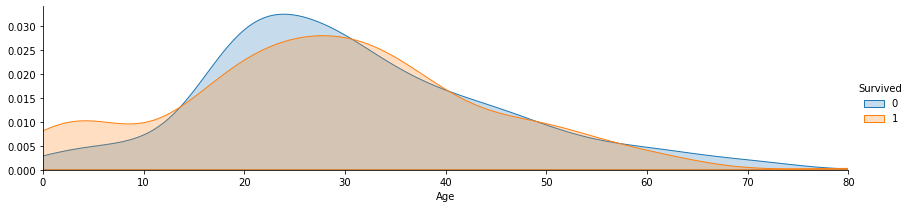

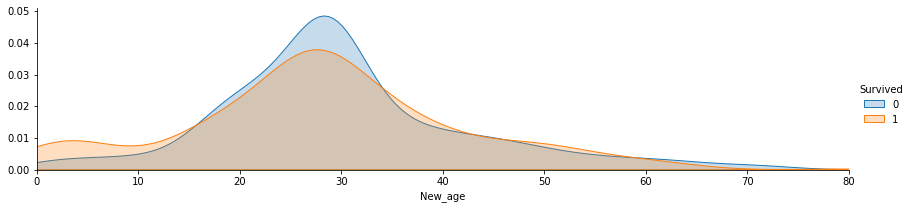

In [23]:
# Age
facetgridplot(data, 'Age')
facetgridplot(data, 'New_age')

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [85]:
# ANSWER
# ANSWER
feature_cols = ['Pclass', 'Parch']
X = data[feature_cols]
y = data['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [86]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [87]:
# ANSWER
# Create Model
logreg = LogisticRegression(solver='liblinear', max_iter=10000)

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [88]:
# ANSWER
# Fit Model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, solver='liblinear')

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [89]:
# ANSWER
logreg.coef_

array([[-0.88004686,  0.33746428]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [90]:
# ANSWER
logreg.intercept_

array([1.33560599])

We can create tuples of the predictor names and coefficients like this:

In [91]:
# ANSWER
print(set(zip(feature_cols, logreg.coef_[0])))

{('Pclass', -0.8800468638257568), ('Parch', 0.3374642759252236)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [92]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.880047
Parch       +0.337464


In [93]:
pd.DataFrame({'feature': feature_cols, 'coefficient': logreg.coef_[0]})

,feature,coefficient
0,Pclass,-0.880047
1,Parch,0.337464


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [94]:
# ANSWER
print('accuracy = {:7.4f}'.format(logreg.score(X_train, y_train)))

accuracy =  0.6924


What is the  `accuracy_score` for the test data?

In [95]:
# ANSWER
print('accuracy = {:7.4f}'.format(logreg.score(X_test, y_test)))

accuracy =  0.6536


What can we say aout this result?

ANSWER
- ...
- ...

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [96]:
# ANSWER
data['Age'].fillna(data.Age.mean(), inplace=True)
feature_cols = ['Pclass', 'Parch', 'Age']
X = data[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [97]:
# Build Model
logreg = LogisticRegression(solver='liblinear', max_iter=10000)

# Fit Model
logreg.fit(X_train, y_train)

# Score
logreg_score = logreg.score(X_train, y_train)
print('accuracy = {:1.4f}'.format(logreg_score))

accuracy = 0.7219


In [98]:
logreg_score = logreg.score(X_test, y_test)
print('accuracy = {:1.4f}'.format(logreg_score))

accuracy = 0.6872


So, including age did little to reduce the variance in our model. Why might this be?

# ANSWER

age is not related to Titanic survival
age is not independent of other features already in the model
imputing the missing values distorted the distribution too much

Let's see where the model is going wrong by showing the Confusion Matrix:

In [42]:
# ANSWER
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[93 13]
 [43 30]]


Nb. Here is how `confusion_matrix` arranges its output:

In [43]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


In [ ]:
cm = confusion_matrix(y_test, y_test)
sns.heatmap(cm,display_labels=['Died', 'Survived'],cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion matrix for logistic regression model')
plt.show()

Accuracy =  0.6871508379888268


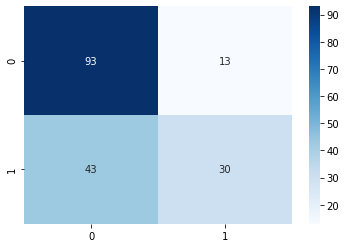

In [47]:
# Plot confusion matrixy_pred_class = logreg.predict(X_test)
ac = accuracy_score(y_test,y_pred_class)
print('Accuracy = ',ac)
cm = confusion_matrix(y_test, y_pred_class)
labels=['Died, Survived']
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues');


In [44]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       106
           1       0.70      0.41      0.52        73

    accuracy                           0.69       179
   macro avg       0.69      0.64      0.64       179
weighted avg       0.69      0.69      0.67       179



Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

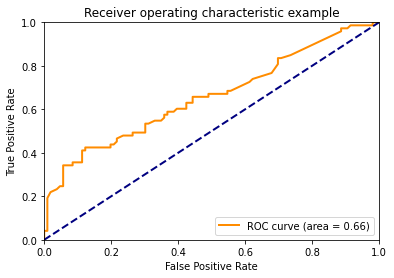

In [68]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [49]:
titanic_with_dummies = pd.get_dummies(data = data, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,New_age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,22.0,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,38.0,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,26.0,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,35.0,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,35.0,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [49]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

In [50]:
titanic_with_dummies['Age']

PassengerId
1      22.000000
2      38.000000
3      26.000000
4      35.000000
5      35.000000
         ...    
887    27.000000
888    19.000000
889    29.699118
890    26.000000
891    32.000000
Name: Age, Length: 891, dtype: float64

In [52]:
titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].mean()

Parch  Sex_male  Pclass_1  Pclass_2
0      0         0         0           26.090266
                           1           31.953294
                 1         0           35.462390
       1         0         0           29.073054
                           1           33.233619
                 1         0           39.789712
1      0         0         0           18.051859
                           1           24.666667
                 1         0           38.276419
       1         0         0           16.917245
                           1           18.107143
                 1         0           44.071429
2      0         0         0           18.035753
                           1           20.454545
                 1         0           22.230769
       1         0         0           16.110866
                           1           19.866000
                 1         0           21.615000
3      0         0         0           36.000000
                           1     

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [71]:
def get_logreg_score(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42)

    # Build Model
    logreg = LogisticRegression(solver='liblinear', max_iter=10000)

    # Fit
    logreg.fit(X_train, y_train)

    # Score
    logreg_score = logreg.score(X_test, y_test)

    # Return accuracy rate
    return logreg_score

In [72]:
# ANSWER
# Set Feature Both Numerical, Categorical
target_col = 'Survived'
feature_cols = ['Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

0.726457399103139

Plot the ROC curve for the new model:

In [73]:
# ANSWER
def plot_roc_curve(X_test, y_test):
    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    preds = logreg.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

Can we improve the model by including the remaining features?

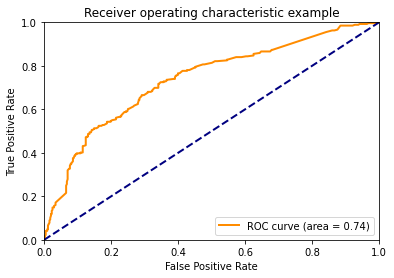

In [74]:
# ANSWER
plot_roc_curve(X_train, y_train)

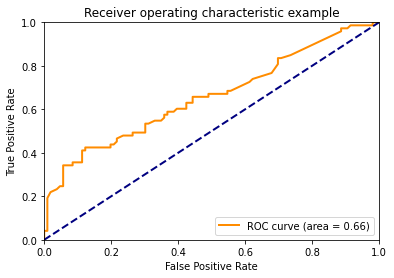

In [75]:
plot_roc_curve(X_test, y_test)

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [58]:
#Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?
from sklearn.model_selection import cross_val_score
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
logreg = LogisticRegression()
scores = cross_val_score(logreg, titanic_with_dummies[feature_cols], titanic_with_dummies[target_col], cv=5)
scores.mean()

C:\Users\nnama\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nnama\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.7935032326909799

3. Look at the fpr & tpr vectors for the best model.

In [99]:
# Build Model
logreg = LogisticRegression()

# Fit
logreg.fit(X_train, y_train)

# Predict
y_pred_class = logreg.predict(X_test)

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[88 18]
 [42 31]]




---



---



> > > > > > > > > © 2021 Institute of Data


---



---



